### Advanced Line Finding

##### Whats done in this project:
1. Import packages and general helper functions

2. Camera calibration

3. Distortion correction

4. Color/gradient threshold

5. Perspective transform

6. Detect lane lines

7. Determine the lane curvature

### 1. Import

In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import time
import math
import os
import ntpath
%matplotlib qt

# save an image given the source, the destination name(ex:'xyz.png') 
# and the desired folder to be stored
def saveImage(source, dest, folder):
    img_path = os.path.join(folder, dest)
    mpimg.imsave(img_path,source)
    
def drawTrapezoid(trapezoidal, left_bottom, left_top, right_top, right_bottom):
    cv2.line(trapezoidal, (left_bottom[0],left_bottom[1]), (right_bottom[0],right_bottom[1]), color=[255, 0, 0], thickness=5)
    cv2.line(trapezoidal, (left_bottom[0],left_bottom[1]), (left_top[0],left_top[1]), color=[255, 0, 0], thickness=5)
    cv2.line(trapezoidal, (left_top[0],left_top[1]), (right_top[0],right_top[1]), color=[255, 0, 0], thickness=5)
    cv2.line(trapezoidal, (right_top[0],right_top[1]), (right_bottom[0],right_bottom[1]), color=[255, 0, 0], thickness=5)
    
    return trapezoidal

def cv2PlotArray(im, xPointArray, yPointArray, iterateIdx, colorRGB):
    im = cv2.circle(im, (int(xPointArray[iterateIdx]),int(yPointArray[iterateIdx])), 
                    2, color = colorRGB , thickness=2)
    
    return im

### 2. Camera calibration

#### a. Calibration helper functions

In [2]:
# this function is used to initialize a subplots array in order 
# to plot all camera calibration images
# IMPORTANT: mandatory call order: calibPlotInit, calibPlotShow, calibPlotDisplayClose
def calibPlotInit(images):
    # create a n-dimensional plotting array
    nSize = math.ceil(math.sqrt(len(images)))  
    
    fig, axs = plt.subplots(plot_cols,plot_rows, figsize=(200, 100))
    fig.suptitle('Calibration Subplots')
    fig.tight_layout()
    calibPlotShow.idx = 0
    calibPlotShow.idy = 0
    return nSize

# this function is used to show all subplots of camera calibration images
# IMPORTANT: mandatory call order: calibPlotInit, calibPlotShow, calibPlotDisplayClose
def calibPlotShow(nSize,img):
    axs[calibPlotShow.idx][calibPlotShow.idy].imshow(img)
        
    if calibPlotShow.idy<plot_cols-1:
        calibPlotShow.idy = calibPlotShow.idy + 1
    else:
        calibPlotShow.idy = 0
        calibPlotShow.idx = calibPlotShow.idx + 1
    time.sleep(0.1)

# display subplot and close all images
# IMPORTANT: mandatory call order: calibPlotInit, calibPlotShow, calibPlotDisplayClose
def calibPlotDisplayClose():
    plt.show()
    plt.close('all')

#### b. Find object and image points and draw them on the calibration images

In [3]:
# prepare object points
NX = 9
NY = 6

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((NX*NY,3), np.float32)
objp[:,:2] = np.mgrid[0:NX,0:NY].T.reshape(-1,2)

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

#nSize = calibPlotInit(images)# Caution: Printing huge subplots take time.

# Step through the list and search for chessboard corners
for fname in images:
    img = mpimg.imread(fname)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (NX, NY), None)
    
    # If found, draw corners
    if ret == True:
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (NX, NY), corners, ret)
        
        # append detected corners
        imgpoints.append(corners)
        objpoints.append(objp)
        
        # calibPlotShow(nSize,img) # Caution: Printing huge subplots take time.
        baseName = ntpath.basename(fname)
        saveImage(img,'2b_chessCorners'+baseName , './output_images/chessCorners/')
        
#calibPlotDisplayClose() # Caution: Printing huge subplots take time.

#### c. Calibrate the camera 

In [4]:
# calibrate the camera with the found obj and img points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

### 3. Distortion correction

#### a. [TEST] undistort a chessboard image

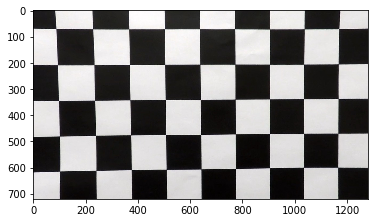

In [5]:
im = mpimg.imread(images[len(images)-1])

#lets try to undistort
dst = cv2.undistort(im, mtx, dist, None, mtx)

saveImage(dst,'3a_chessUndist.jpg', './output_images/')
saveImage(img,'3a_chessDist.jpg', './output_images/')
plt.imshow(dst)

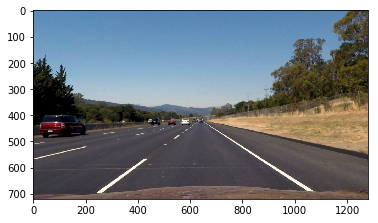

In [6]:
im = mpimg.imread('./test_images/straight_lines2.jpg')

#lets try to undistort
dst = cv2.undistort(im, mtx, dist, None, mtx)

saveImage(dst,'3a_undist.jpg', './output_images/')
plt.imshow(dst)

### 4. Color/gradient threshold

#### a. Separate S channel from HLS image

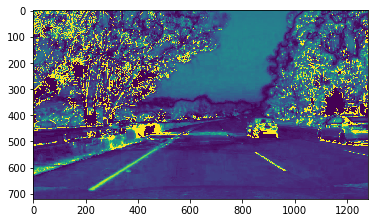

In [7]:
img = mpimg.imread('./test_images/test5.jpg')

hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

# get channel S only
s_channel = hls[:,:,2]

plt.imshow(s_channel)
saveImage(s_channel,'4a_s_channel.jpg', './output_images/')

#### b. Binary threshold the S channel

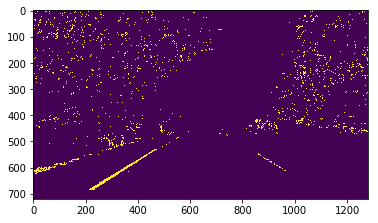

In [8]:
# Binary threshold color channel
s_thresh_min = 170#170
s_thresh_max = 250#250
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
plt.imshow(s_binary)
saveImage(s_binary,'4b_s_binary.jpg', './output_images/')

#### c. Determine the x-axis scaled Sobel for grayscale image

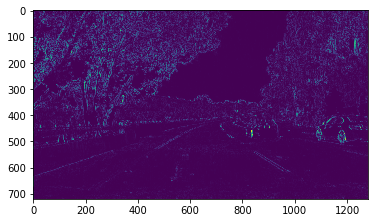

In [9]:
# Grayscale image
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # x axis sobel
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx)) #scale the x sobel 
plt.imshow(scaled_sobel)
saveImage(scaled_sobel,'4c_scaled_sobel.jpg', './output_images/')

#### d. Binary threshold the gray x-sobel image

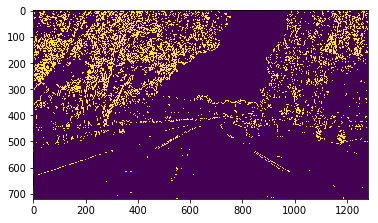

In [10]:
thresh_min = 20#20
thresh_max = 100#100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
plt.imshow(sxbinary)
saveImage(sxbinary,'4d_scaled_sobel_binary.jpg', './output_images/')

#### e. Stack and combine the saturation channel and gray channel binary thresholds

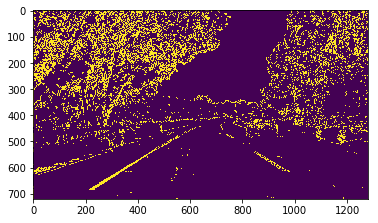

In [11]:
# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

saveImage(color_binary,'4e_color_binary.jpg', './output_images/')

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
plt.imshow(combined_binary)
saveImage(combined_binary,'4e_combined_binary.jpg', './output_images/')

#### f. Color/Gradient function

In [12]:
def colorGradientThresh(im):
    hls = cv2.cvtColor(im, cv2.COLOR_RGB2HLS)
    
    s_channel = hls[:,:,2]

    s_thresh_min = 170
    s_thresh_max = 250
    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx) 
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    #sxbinary = cv2.cvtColor(sxbinary, cv2.COLOR_RGB2GRAY)
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

### 5. Perspective transformation

#### a. Define a trapezoid from the original image for perspective transformation

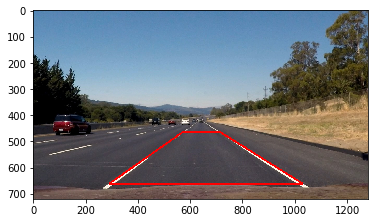

In [13]:
# read image with straight lines
image = mpimg.imread('./test_images/straight_lines2.jpg')

# handpicked points on the image of a straigh lane
# Note: coresponds to image straight_lines2.jpg
left_bottom = np.array([291, 661])
left_top = np.array([571, 465])#np.array([601, 444])
right_bottom = np.array([1030, 661])
right_top = np.array([716, 465])#np.array([681, 444])

#create a copy to remove read_only
img = np.copy(image)

trapezImg = drawTrapezoid(np.copy(image), left_bottom, left_top, right_top, right_bottom)

saveImage(trapezImg,'5a_transRegion.jpg', './output_images/')
plt.imshow(trapezImg)

#### b. Undistort & warp perspective

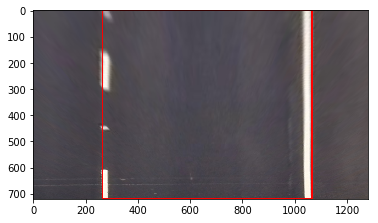

In [14]:
src = np.float32([[left_bottom], [left_top], [right_bottom], [right_top]])

warp_LB = np.array([265,720])#265/345 - default size(narrow it with 80 pixels to capture the full curvature)
warp_LT = np.array([265,0])
warp_RB = np.array([1065,720])#1065/985
warp_RT = np.array([1065,0])

dst = np.float32([[warp_LB], [warp_LT], [warp_RB], [warp_RT]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

dst = cv2.undistort(img, mtx, dist, None, mtx)

img_size = (img.shape[1],img.shape[0])
warped = cv2.warpPerspective(dst, M, img_size, flags=cv2.INTER_LINEAR)

trapezImg = drawTrapezoid(np.copy(warped), warp_LB, warp_LT, warp_RT, warp_RB)

saveImage(trapezImg,'5b_undistWarped.jpg', './output_images/')
plt.imshow(trapezImg)

#### c. Undistort and Warp function

In [15]:
def undistWarp(im):
    dst = cv2.undistort(im, mtx, dist, None, mtx)

    im = cv2.warpPerspective(dst, M, img_size, flags=cv2.INTER_LINEAR)
    return im

def unWarp(im):
    im = cv2.warpPerspective(dst, Minv, img_size, flags=cv2.INTER_LINEAR)
    return im

#### d. [Test] Lets try with and curved lane

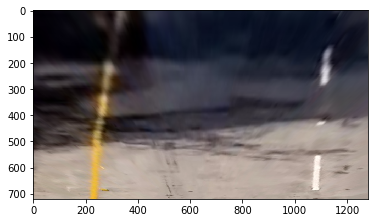

In [16]:
image = mpimg.imread('./test_images/test5.jpg')

warped = undistWarp(image)

saveImage(warped,'5d_curvedTransform.jpg', './output_images/')
plt.imshow(warped)

### 6. Detect Lines

#### a. Plot histogram for bottom half of binary image

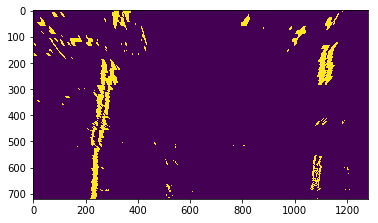

In [17]:
threshImg = colorGradientThresh(image)

warped = undistWarp(threshImg)

bottom_half = warped[warped.shape[0]//2:,:]

histogram = np.sum(bottom_half, axis=0)

plt.imshow(warped)

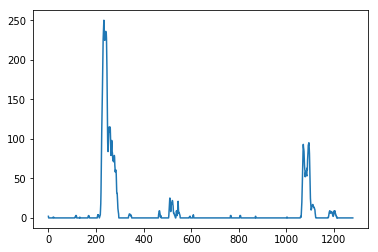

In [18]:
plt.plot(histogram)

#### b. Find pixels belonging to each line through the sliding window method

In [19]:
#taken from: Finding the Lines: Sliding Window
def find_lane_pixels(binary_warped):
    # these variables are set outside the function and needs to hold values
    # between calls
    global minimumWidth, firstFrame, lxl, lxr, rxl, rxr, leftx_base, rightx_base
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    midpoint = np.int(histogram.shape[0]//2)
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 100
    # Allowed deviation of the first windows
    windowmargin = 30

    # if this is the first frame calculate 
    # the peak of the left and right halves of the histogram
    # and the distance between lines
    if firstFrame == True:
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        minimumWidth = rightx_base - leftx_base - windowmargin
        firstFrame = False
    else:
        # if the lanes dont get to close to each other
        # then calculate the reduced window for where to look
        # for peaks.
        if (rightx_base-leftx_base) > minimumWidth:
            lxl = leftx_base - windowmargin
            lxr = leftx_base + windowmargin

            rxl = rightx_base - windowmargin
            rxr = rightx_base + windowmargin

        leftx_base = np.argmax(histogram[lxl:lxr]) + lxl
        rightx_base = np.argmax(histogram[rxl:rxr]) + rxl
    


    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

#### c. Fit a polynomial to the lines

In [20]:
#taken from: Finding the Lines: Sliding Window
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    return out_img, left_fitx, right_fitx, ploty

#### d. [test] Lets test the polynomial fit and sliding windows method

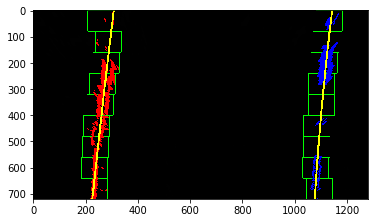

In [21]:
# Take a histogram of the bottom half of the image
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)

firstFrame = True
out_img, left_fitx, right_fitx, ploty = fit_polynomial(warped)

# Plots the left and right polynomials on the lane lines
for idx in range(len(ploty)):
    out_img = cv2PlotArray(out_img, left_fitx, ploty, idx, (255, 255, 0))
    out_img = cv2PlotArray(out_img, right_fitx, ploty, idx, (255, 255, 0))

saveImage(out_img,'6d_slidingWindow.jpg', './output_images/')
plt.imshow(out_img)

### 7. Determine the lane curvature and vehicle position

#### a. Measure lane curvature in meters

In [22]:
def measure_curvature_real(ploty, leftx, rightx):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

    # Fit a second order polynomial to pixel positions in each fake lane line
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1]) **2)**1.5) / np.absolute(2* left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    meanCurvature = (left_curverad + right_curverad)/2

    return int(meanCurvature)

#### b. Vehicle position

In [23]:
def calculateShift(im, left_fitx, right_fitx):
    leftXLane = left_fitx[len(left_fitx)-1]
    rightXLane = right_fitx[len(right_fitx)-1]
    cameraWidth = im.shape[1]
    lanePixWidth = rightXLane - leftXLane
    cameraLaneDiff = (cameraWidth - lanePixWidth)/2 #calculate the equal distance between lane widht and image width
    shiftCamera = leftXLane-cameraLaneDiff
    xm_per_pix = 3.7/1280 # meters per pixel in x dimension
    shiftDist = round(shiftCamera * xm_per_pix, 2)
    
    if(shiftDist>0):
        shiftDir = "left"
    else:
        shiftDir = "right" 
    return abs(shiftDist), shiftDir

# Pipeline

#### a. Pipeline functions

In [24]:
def drawGradientHisto(im, gradientImg):
    bottom_half = gradientImg[gradientImg.shape[0]//2:,:]
    histo = np.sum(bottom_half, axis=0)
    
    yStep = int(gradientImg.shape[1]/len(histo))
    yArray = np.arange(0,gradientImg.shape[1],yStep)
    for idx in range(len(histo)):
        histImage = cv2PlotArray(im, yArray, histo, idx, (255, 0, 0))
    
    return histImage

def drawTextAtYPos(im,yPos,text):
    # font 
    font = cv2.FONT_HERSHEY_SIMPLEX 
    # org 
    org = (50, yPos) 
    # fontScale 
    fontScale = 1
    # White color in BGR 
    color = (255, 255, 255) 
    # Line thickness of 2 px 
    thickness = 2
   
    result = cv2.putText(im, text, org, font,  fontScale, color, thickness, cv2.LINE_AA) 

    return im

#### b. Build video pipeline

In [25]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def pipeline(originalImage):
    global foundX
    image_copy = np.copy(originalImage)
    
    undistWarpedImage = undistWarp(image_copy)
    gradientImage = colorGradientThresh(undistWarpedImage)
    
    processedImage, left_fitx, right_fitx, ploty = fit_polynomial(gradientImage) 
    meanCurvature = measure_curvature_real(ploty, left_fitx, right_fitx)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(gradientImage).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(originalImage, 1, newwarp, 0.3, 0)
    
    result = drawTextAtYPos(result, 50, 'Radius of Curvature = ' + str(meanCurvature) +"(m)")
    
    shiftCamera,shiftDirection = calculateShift(result, left_fitx, right_fitx)
    result = drawTextAtYPos(result, 100, 'Vehicle is shifted with ' + str(shiftCamera) +"(m) to the "+shiftDirection)
    
    return result

firstFrame = True
clip1 = VideoFileClip("./project_video.mp4")#.subclip(0,3)
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
white_output = './project_video_full.mp4'
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./project_video_full.mp4
[MoviePy] Writing video ./project_video_full.mp4


100%|█████████▉| 1260/1261 [04:20<00:00,  4.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_full.mp4 

CPU times: user 1min 54s, sys: 22.3 s, total: 2min 16s
Wall time: 4min 22s
